# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
RANDOM_STATE = 42

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [3]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isna().sum()[df.isna().sum()>0]

balance    25
dtype: int64

### Задание 2

In [4]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
list(df['job'].unique())

['admin.',
 'technician',
 'services',
 'management',
 'retired',
 'blue-collar',
 'unemployed',
 'entrepreneur',
 'housemaid',
 'unknown',
 'self-employed',
 'student']

### Задание 3

In [5]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].str.replace('$','')
df['balance'] = df['balance'].str.replace(',','.')
df['balance'] = df['balance'].str.replace(' ','')
df = df.astype({'balance': np.float})
print(round(df['balance'].mean(),3))

1529.129


### Задание 4

In [6]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
temp_median = df['balance'].median()
df['balance'] = df['balance'].fillna(temp_median)
print(round(df['balance'].mean(),3))

1526.936


### Задание 5

In [7]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
print(df['job'].value_counts().index[0])
df['job'] = df['job'].replace('unknown',df['job'].value_counts().index[0])
df['education'] = df['education'].replace('unknown',df['education'].value_counts().index[0])


management


### Задание 6

In [8]:
# удалите все выбросы для признака balance
Q1 = df['balance'].quantile(.25)
Q3 = df['balance'].quantile(.75)
IQR = Q3-Q1
Q_min = Q1-1.5*IQR
Q_max = Q3+1.5*IQR
df = df[(df['balance']>=Q_min) & (df['balance']<=Q_max)]
df.shape[0]

10105

## Часть 2:  Разведывательный анализ

### Задание 1

In [9]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
print(df['deposit'].value_counts())

no     5424
yes    4681
Name: deposit, dtype: int64


### Задания 2 и 3

In [10]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


#### Оценим описательные статистики числовых признаков:

- Признак **age** имеет разброс от 18 до 95 лет, с медианным 38 и средним 40.9 лет значениями. Что говорит о преобладании среди клиентов людей среднего возраста, а средние меры (медиана меньше средне арифметического) говорят о преимущественно молодом возрасте клиентов, а так же не исключено влияние выбросов. Расмотрим это предположение подробнее.


- Признак **balance** имеет разброс от -2049 до 4063, с медианным 445 и средним 994 значениями. Что говорит о, в целом не больших суммах накоплений, о чём дополниельно говорит меньшее значение медианы в сравнении с средне арифметическим), а так же не исключено влияние выбросов. Расмотрим это предположение подробнее.


- Признак **day** имеет разброс от 1 до 31, с медианным 15 и средним 15.6 значениями. Что позволяет предположить близкое к нормальному распредление значений, при средних значениях около 2-х недель. Расмотрим это предположение подробнее.


- Признак **duration** имеет разброс от 2 до 3881, с медианным 252 и средним 368.7 значениями. Что может говорить о наличии выбросов. Расмотрим это предположение подробнее.


- Признак **campaign** имеет разброс от 1 до 43, с медианным 2 и средним 2.5 значениями. Что говорит о в среднем не большом количестве контактов в районе 2, так и вероятном наличии выбросов. Расмотрим это предположение подробнее.


- Признак **pdays** имеет разброс от -1 до 854, с медианным -1 и средним 51 значениями. Что может говорить о использовании значения -1, как признака отсутсвия контактов, причём таковых значений должно быть много. Эта гипотеза нуждается в проверке.


- Признак **previous** имеет разброс от 0 до 58, с медианным 0 и средним 0.8 значениями. Что может говорить о использовании значения 0, как признака отсутсвия контактов, причём таковых значений должно быть много. Эта гипотеза так же нуждается в проверке.

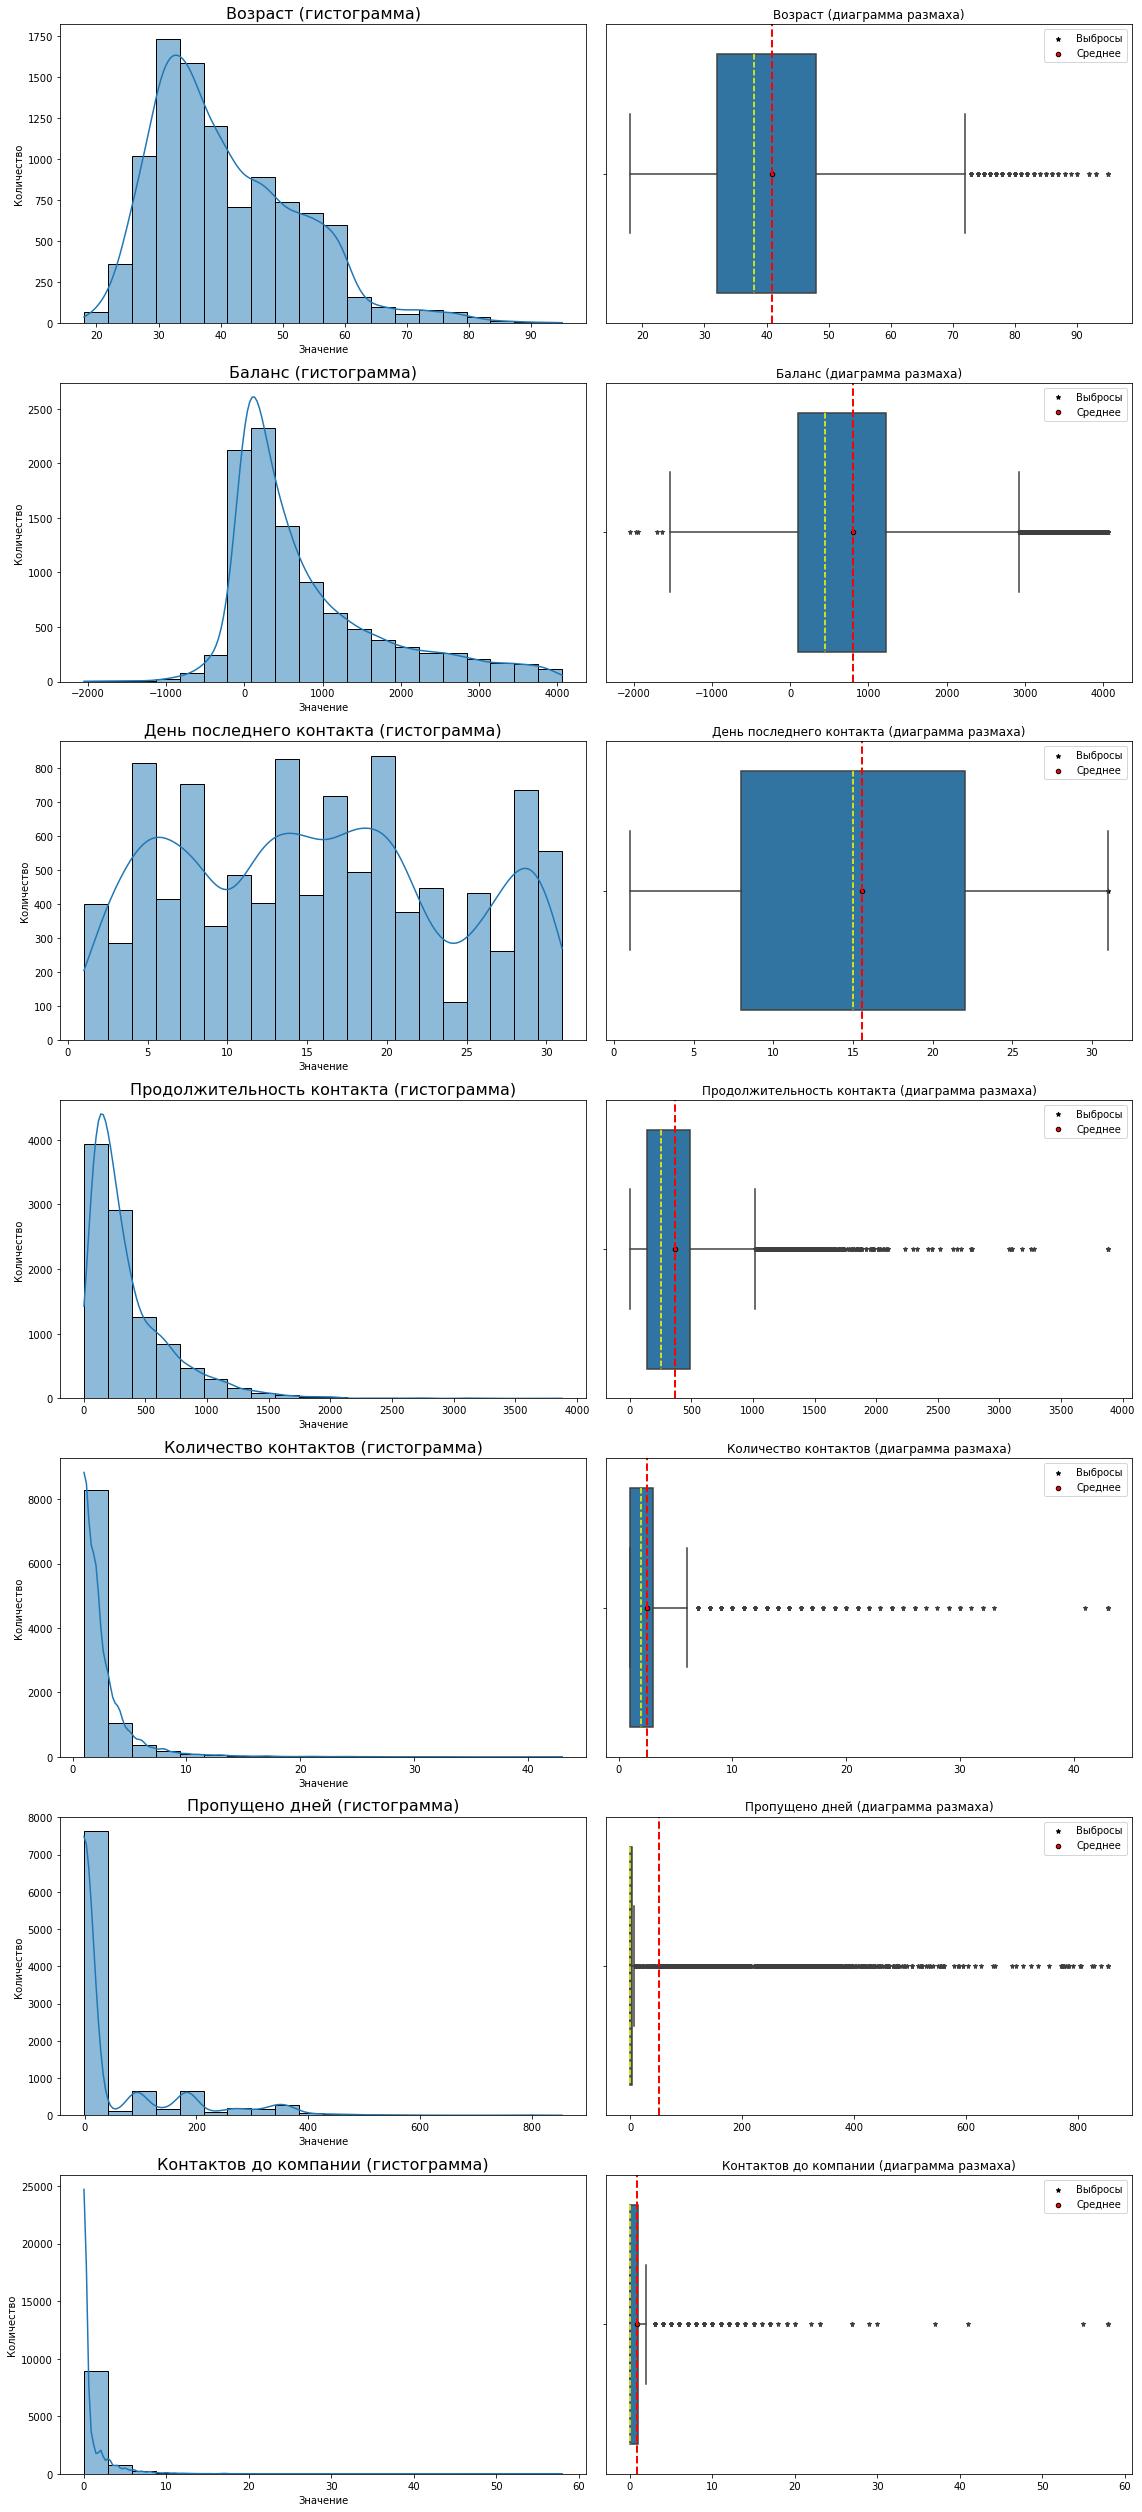

In [11]:
# Построим графики ля визуализации особенностей распределения и проверки гипотез
def stat_graf_bild(columns_list, title_list): 
    '''Функция строит гистограмму и диаграмму распределения для, 
    переданных в списке, колонок датафрейма

    Args:
        columns_list (list): список колонок
        title_list (list): списко подписей для графиков
        
    Returns: значения не возвращаются  
    '''
    total_axes = len(columns_list)
    fig = plt.figure(figsize=(16, total_axes*5))
    subplt = 1
    for i, column in enumerate(columns_list):
        axes = fig.add_subplot(total_axes, 2, subplt) 
        sns.histplot(data=df[column], 
             bins=20, 
             ax=axes, 
             kde=True)
        axes.set_title('{} (гистограмма)'.format(title_list[i]), 
                  fontsize=16)
        axes.set_xlabel('Значение')
        axes.set_ylabel('Количество')
        subplt+=1
    
        axes1 = fig.add_subplot(total_axes, 2, subplt) 
        sns.boxplot(df[column], 
            ax=axes1, 
            orient='h', 
            flierprops={"marker": "*"},
            medianprops={"color": "yellow", 
                         "linestyle": '--'})
        axes1.set(ylabel='')
        axes1.set_title('{} (диаграмма размаха)'.format(title_list[i], 
                  fontsize=16))
        axes1.set_xlabel('')
        plt.scatter(df[column].max(), 
            0, marker='*', 
            s=20, 
            color = 'black', 
            label = 'Выбросы')
        plt.scatter(df[column].mean(), 
            0, 
            marker='o', 
            s=20, 
            color = 'red', 
            edgecolors = 'black', 
            label = 'Среднее')
        axes1.axvline(df[column].mean(),
             color='red', 
             linestyle='--', 
             linewidth=2)
        plt.legend()
        subplt+=1

    plt.tight_layout()
    plt.show()

# получаем списко колонок с чиловыми значениями и строим графики
columns_list = df.select_dtypes(include=['float64', 'int64']).columns.to_list()
title_list = ['Возраст','Баланс','День последнего контакта',
              'Продолжительность контакта','Количество контактов',
              'Пропущено дней','Контактов до компании']
stat_graf_bild(columns_list, title_list)

- Из графиков для признака **age** можно увидеть, что распределение признака близко к логнормальному, с преобладанием молодых людей в возрасте от 18 до 40 лет, так же достаточно велико количество людей от 40 до 60 лет. Таким образом можно выделить 3 возрастных категории от 18 до 40, с 40 до 60 и старше 60 лет. Так же подтверждается предположение о правом хвосте распределения, что можно рассматривать как выбросы для возрастов более 80 лет.


- Из графиков для признака **balance** можно увидеть, что распределение похоже на логнормальное, с более выраженным правым хвостом. Отчётливо видно смещение среднего значения вправо от медианного значения, Причиной чего в основном является выраженный правый хвост распределения, смещающий выборку.


- Из графиков для признака **day** можно увидеть, что распределение ближе к линейному. С умеренным смещением среднего значения вправо от медианного значения. Выбросов нет.


- Из графиков для признака **duration** можно увидеть, что распределение похоже на логнормальное, с значительно выраженным длинным правым хвостом. Отчётливо видно смещение среднего значения вправо от медианного значения, Причиной чего в основном является выраженный правый хвост распределения, большое количество выбросов.


- Из графиков для признака **campaign** можно увидеть, что распределение похоже на логнормальное, с резким смещением максимума влево и значительно выраженным длинным правым хвостом. Отчётливо видно смещение среднего значения вправо от медианного значения, Причиной чего в основном является выраженный правый хвост распределения, и большое количество выбросов.


- Из графиков для признака **pdays** можно увидеть, что распределение похоже на логнормальное, с резким смещением максимума влево и значительно выраженным длинным правым хвостом. Отчётливо видно смещение среднего значения вправо от медианного значения, Причиной чего в основном является выраженный правый хвост распределения, и большое количество выбросов.


- Из графиков для признака **previous** можно увидеть, что распределение похоже на логнормальное, с резким смещением максимума влево и значительно выраженным длинным правым хвостом. Отчётливо видно смещение среднего значения вправо от медианного значения, Причиной чего в основном является выраженный правый хвост распределения, и большое количество выбросов.

### Задания 4 и 5

In [12]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


По результатам первичного анализа описательных статистик можно увидеть, что количество значений каждой из переменых не велико, что позволяет на их основе построить категориальные признаки. Более подробно распределение признаков можно увидеть на графиках, отражающих соотношение значений каждого признака.

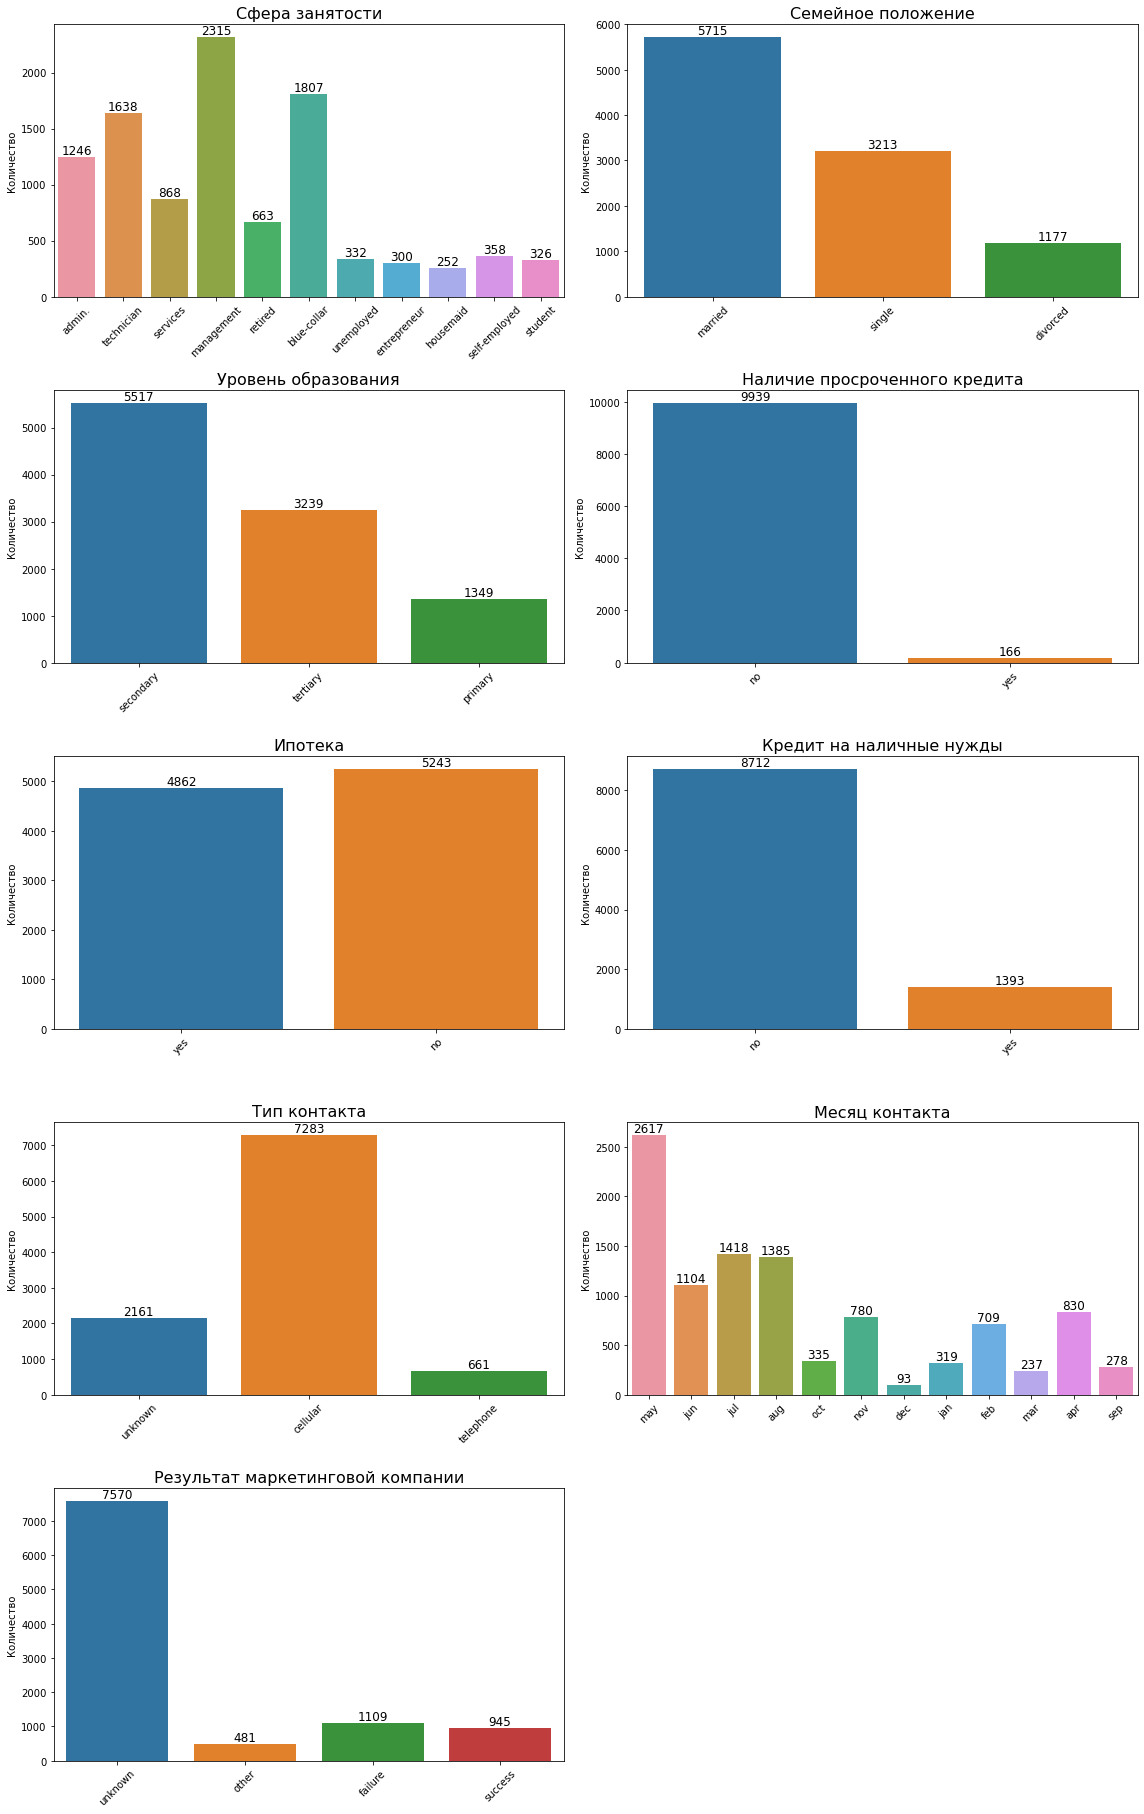

In [13]:
#постройте визуализации, иллюстрирующие результаты
# отобразим соотношение на графиках

def stat_graf_bild_object(columns_list, title_list): 
    '''Функция строит диаграмму распределения для, 
    переданных в списке, колонок датафрейма

    Args:
        columns_list (list): список колонок
        title_list (list): списко подписей для графиков
        
    Returns: значения не возвращаются  
    '''
    total_axes = len(columns_list)
    fig = plt.figure(figsize=(16, total_axes*5))
    subplt = 1
    for i, column in enumerate(columns_list):
        axes = fig.add_subplot(total_axes, 2, subplt) 
        bar_types = sns.countplot(data=df, x=column, ax=axes)
        axes.set(xlabel='', ylabel='Количество')
        axes.set_title('{}'.format(title_list[i]), fontsize=16)
        subplt+=1
        plt.xticks(rotation = 45)
        
        for p in bar_types.patches:
            bar_types.annotate('{:.0f}'.format(p.get_height()), 
                       (p.get_x()+0.4, p.get_height()+0.01),
                       ha='center', 
                       va='bottom', 
                       fontsize=12)
    plt.tight_layout()
    plt.show()                


# получаем списко колонок с чиловыми значениями и строим графики
columns_list_object = df.select_dtypes(include=['object']).columns.to_list()
columns_list_object.pop()
title_list_object = ['Сфера занятости','Семейное положение','Уровень образования',
              'Наличие просроченного кредита','Ипотека',
              'Кредит на наличные нужды','Тип контакта','Месяц контакта',
              'Результат маркетинговой компании']
stat_graf_bild_object(columns_list_object, title_list_object)

In [14]:
df['poutcome'].value_counts().index

Index(['unknown', 'failure', 'success', 'other'], dtype='object')

На графиках можно увидеть значительно различающийся для различных признаков разброс, а именно:
- Признак **job** наибольшее количество клиентов относится к 4 категориям ('management', 'blue-collar', 'technician', 'admin.'), остальных значительно меньше. Преобладающей является 'management' со значением 2315. 


- Признак **marital** практически половина относится к категории 'married', наименьшее же количество из категории  'divorced'.


- Признак **education** в этой категории распределение напоминает предыдущее в количественном отношении, лидер 'secondary' - 5517, наименьшее количесво в категории 'primary' - 1349.


- Признак **default** количество просроченных кредитов не велико, всего 166 записей, что составляет 1.6%.


- Признак **housing** количество клиентов, имеющих ипотеку немногим меньше половины - 4862. 


- Признак **loan** основная масса клиентов имеет кредит на наличные нужды - 8712 записей.


- Признак **contact** наибольшее количество контактов осуществлялось по каналу 'cellular' - 7283 клиента выборки.


- Признак **month** наибольшее количество контактов осуществлялось в мае - 2617, заметно меньше в июле и августе 1418 и 1385 соответственно.


- Признак **poutcome** - результаты предыдущей компании в подавляющем большинстве случав неизвестны, из остальных наибольшее количество в группе 'failure' - 1109.

### Задание 6

In [15]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код

temp_df = df[['poutcome','deposit']]
temp_df['deposit'] = df['deposit'].apply(lambda x: 1 if x=='yes' else 0)
cross_table = temp_df.groupby(
    ['poutcome'])['deposit'].mean()*100
cross_table.sort_values(ascending=False)

poutcome
success    91.111111
other      55.093555
failure    49.323715
unknown    39.735799
Name: deposit, dtype: float64

### Задание 7

In [16]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит

temp_df = df[['month','deposit']]
temp_df['deposit'] = df['deposit'].apply(lambda x: 1 if x=='yes' else 0)
cross_table = temp_df.groupby(
    ['month'])['deposit'].mean()*100
cross_table.sort_values(ascending=True)

month
may    32.136034
jan    39.184953
jul    41.043724
nov    41.538462
aug    44.043321
jun    45.108696
feb    54.442877
apr    61.807229
oct    81.492537
sep    83.453237
mar    89.873418
dec    90.322581
Name: deposit, dtype: float64

### Задание 8

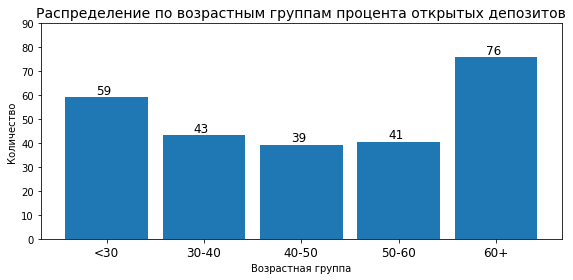

In [17]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит,
# чем отказываться от предложения

def sort_age_groups(age):
    age_group = 0
    if age < 30:
        age_group = 1
    if (age >= 30) and (age < 40):
        age_group = 2
    if (age >= 40) and (age < 50):
        age_group = 3
    if (age >= 50) and (age < 60):
        age_group = 4
    if age >= 60:
        age_group = 5
    return age_group

df['age_groups'] = df['age'].apply(sort_age_groups)
temp_df['age_groups'] = df['age'].apply(sort_age_groups)
temp_df['deposit'] = df['deposit'].apply(lambda x: 1 if x=='yes' else 0)
cross_table = temp_df.groupby(['age_groups'])['deposit'].mean()*100

sign_list = ['<30','30-40','40-50','50-60','60+']
fig, axes= plt.subplots(figsize=(8, 4))
bar_types = cross_table.plot(
    ax=axes, 
    kind='bar', 
    width=0.85, 
    rot=0)
axes.set(xlabel='Возрастная группа', ylabel='Количество')
axes.set_title('Распределение по возрастным группам процента открытых депозитов'
               ,fontsize=14)
plt.xticks([0,1,2,3,4], sign_list, fontsize=12)
       
for p in bar_types.patches:
    bar_types.annotate('{:.0f}'.format(p.get_height()),
                       (p.get_x()+0.4, p.get_height()+0.1),
                       ha='center',
                       va='bottom',
                       fontsize=12)
plt.tight_layout()
plt.ylim(0, 90)
plt.show() 

Более склонными к открытию депозитов оказались возрастные группы **<30**  и **60+**.

### Задания 9 и 10

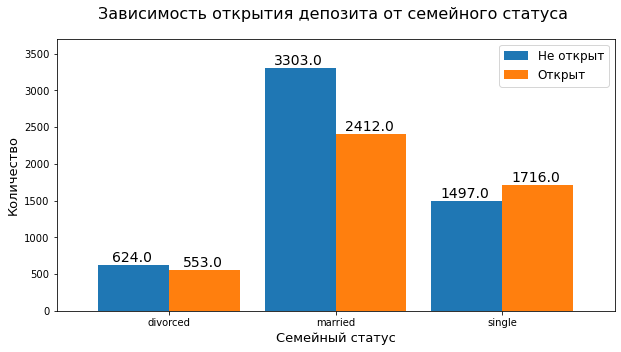

In [18]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

temp_df = df[['marital','deposit']]
cross_table = temp_df.groupby(
    ['marital','deposit'])['deposit'].count().unstack()

fig, axes= plt.subplots(figsize=(10, 5))
bar_types = cross_table.plot(
    ax=axes, 
    kind='bar', 
    width=0.85, 
    rot=0)
axes.set_title('Зависимость открытия депозита от семейного статуса ', 
               pad=20, 
               size=16)
axes.set_xlabel('Семейный статус', 
                fontsize=13)
axes.set_ylabel('Количество', 
                fontsize=13)
axes.legend(['Не открыт', 'Открыт'], 
            loc='upper right', 
            fontsize=12)

for num in bar_types.patches:
    bar_types.annotate(
        '{:.1f}'.format(num.get_height()), 
        (num.get_x()+0.2, 
        num.get_height()),
        ha='center', 
        va='bottom', 
        fontsize=14)

plt.ylim(0, 3700)
plt.show();

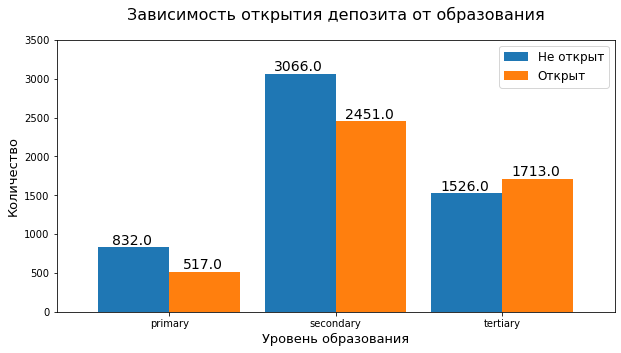

In [19]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

temp_df = df[['education','deposit']]
cross_table = temp_df.groupby(
    ['education','deposit'])['deposit'].count().unstack()

fig, axes= plt.subplots(figsize=(10, 5))
bar_types = cross_table.plot(
    ax=axes, 
    kind='bar', 
    width=0.85, 
    rot=0)
axes.set_title('Зависимость открытия депозита от образования', 
               pad=20, 
               size=16)
axes.set_xlabel('Уровень образования', 
                fontsize=13)
axes.set_ylabel('Количество', 
                fontsize=13)
axes.legend(['Не открыт', 'Открыт'], 
            loc='upper right', 
            fontsize=12)

for num in bar_types.patches:
    bar_types.annotate(
        '{:.1f}'.format(num.get_height()), 
        (num.get_x()+0.2, 
        num.get_height()),
        ha='center', 
        va='bottom', 
        fontsize=14)

plt.ylim(0, 3500)
plt.show();

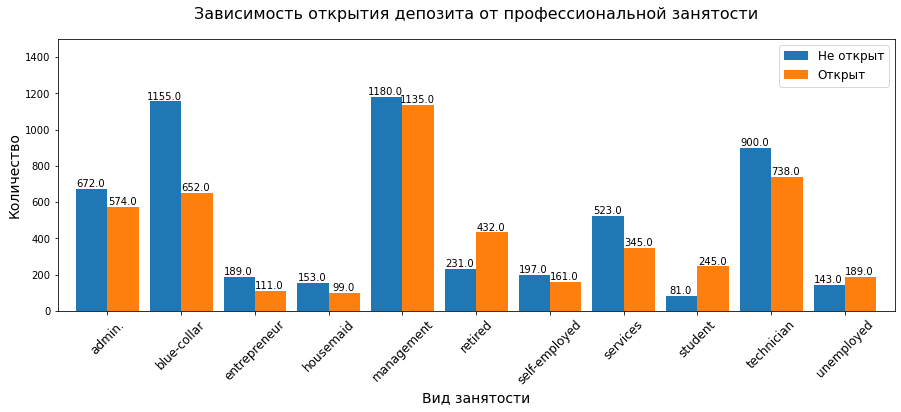

In [20]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

temp_df = df[['job','deposit']]
cross_table = temp_df.groupby(
    ['job','deposit'])['deposit'].count().unstack()

fig, axes= plt.subplots(figsize=(15, 5))
bar_types = cross_table.plot(
    ax=axes, 
    kind='bar', 
    width=0.85, 
    rot=0)
axes.set_title('Зависимость открытия депозита от профессиональной занятости', 
               pad=20, 
               size=16)
axes.set_xlabel('Вид занятости', 
                fontsize=14)
axes.set_ylabel('Количество', 
                fontsize=14)
axes.legend(['Не открыт', 'Открыт'], 
            loc='upper right', 
            fontsize=12)
plt.xticks(fontsize=12, rotation = 45)

for num in bar_types.patches:
    bar_types.annotate(
        '{:.1f}'.format(num.get_height()), 
        (num.get_x()+0.2, 
        num.get_height()),
        ha='center', 
        va='bottom', 
        fontsize=10)

plt.ylim(0, 1500)
plt.show();

### Задание 11

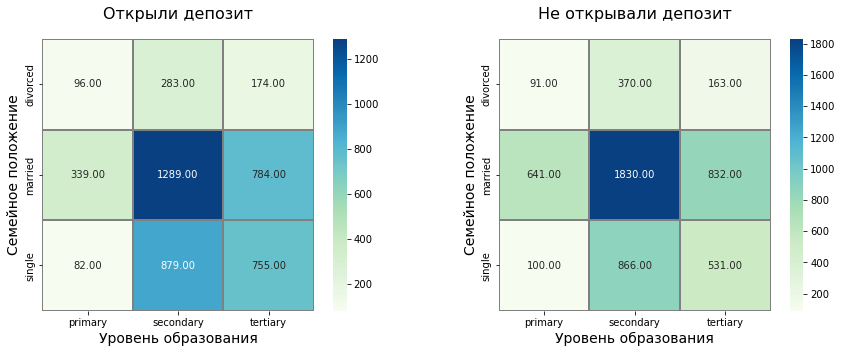

In [21]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

temp_df = df[['marital','education','deposit']]
temp_df['deposit'] = temp_df['deposit'].apply(lambda x: 1 if x=='yes' else 0)
temp_df_yes = temp_df[temp_df['deposit']==1]
temp_df_no = temp_df[temp_df['deposit']==0]

pivot_table_yes = pd.pivot_table(temp_df_yes,                                  
                                 index=['marital'],
                                 columns=['education'], 
                                 values='deposit',
                                 aggfunc='count')

pivot_table_no = pd.pivot_table(temp_df_no,                                  
                                 index=['marital'],
                                 columns=['education'], 
                                 values='deposit',
                                 aggfunc='count')

fig, axes = plt.subplots(1, 2, figsize=(15,5))
heatmap1 = sns.heatmap(
    pivot_table_yes, 
    linewidth=0.1, 
    linecolor='gray',
    cmap='GnBu',
    annot = True,
    fmt='.2f',
    square=True,
    ax = axes[0]
)
axes[0].set_title('Открыли депозит', 
               pad=20, 
               size=16)
axes[0].set_xlabel('Уровень образования', 
                fontsize=14)
axes[0].set_ylabel('Семейное положение', 
                fontsize=14)

heatmap2 = sns.heatmap(
    pivot_table_no, 
    linewidth=0.1, 
    linecolor='gray',
    cmap='GnBu',
    annot = True,
    fmt='.2f',
    square=True,
    ax = axes[1]
)
axes[1].set_title('Не открывали депозит', 
               pad=20, 
               size=16)
axes[1].set_xlabel('Уровень образования', 
                fontsize=14)
axes[1].set_ylabel('Семейное положение', 
                fontsize=14);

## Часть 3: преобразование данных

### Задание 1

In [22]:
# преобразуйте уровни образования

le = LabelEncoder()
df['education'] = le.fit_transform(df['education'])
print('Сумма получившихся значений для признака "education" = {}'.format(df['education'].sum()))

Сумма получившихся значений для признака "education" = 11995


### Задания 2 и 3

In [23]:
# преобразуйте бинарные переменные в представление из нулей и единиц

df['deposit'] = df['deposit'].apply(lambda x: 1 if x=='yes' else 0)
print('Стандартное отклонение целевой переменной "deposit" = {}'.format(
                                                round(df['deposit'].std(),3)))

df['default'] = df['default'].apply(lambda x: 1 if x=='yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x=='yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x=='yes' else 0)
sum_mean = df['default'].mean()+df['housing'].mean()+df['loan'].mean()
print('Сумма средних значений = {}'.format(round(sum_mean,3)))

Стандартное отклонение целевой переменной "deposit" = 0.499
Сумма средних значений = 0.635


### Задание 4

In [24]:
# создайте дамми-переменные
                             
column_list = ['job', 'marital', 'contact', 'month', 'poutcome']
tdf = df[column_list]
ohe = OneHotEncoder()
temp_df = pd.DataFrame(ohe.fit_transform(tdf).toarray(), 
                       columns = ohe.get_feature_names(tdf.columns))
df = df.reset_index()
df = df.drop(['index'], axis = 1)
df = pd.concat([df, temp_df], axis=1)
print(len(df.columns)-1)
df = df.drop(column_list, axis = 1)

50


### Задания 5 и 6

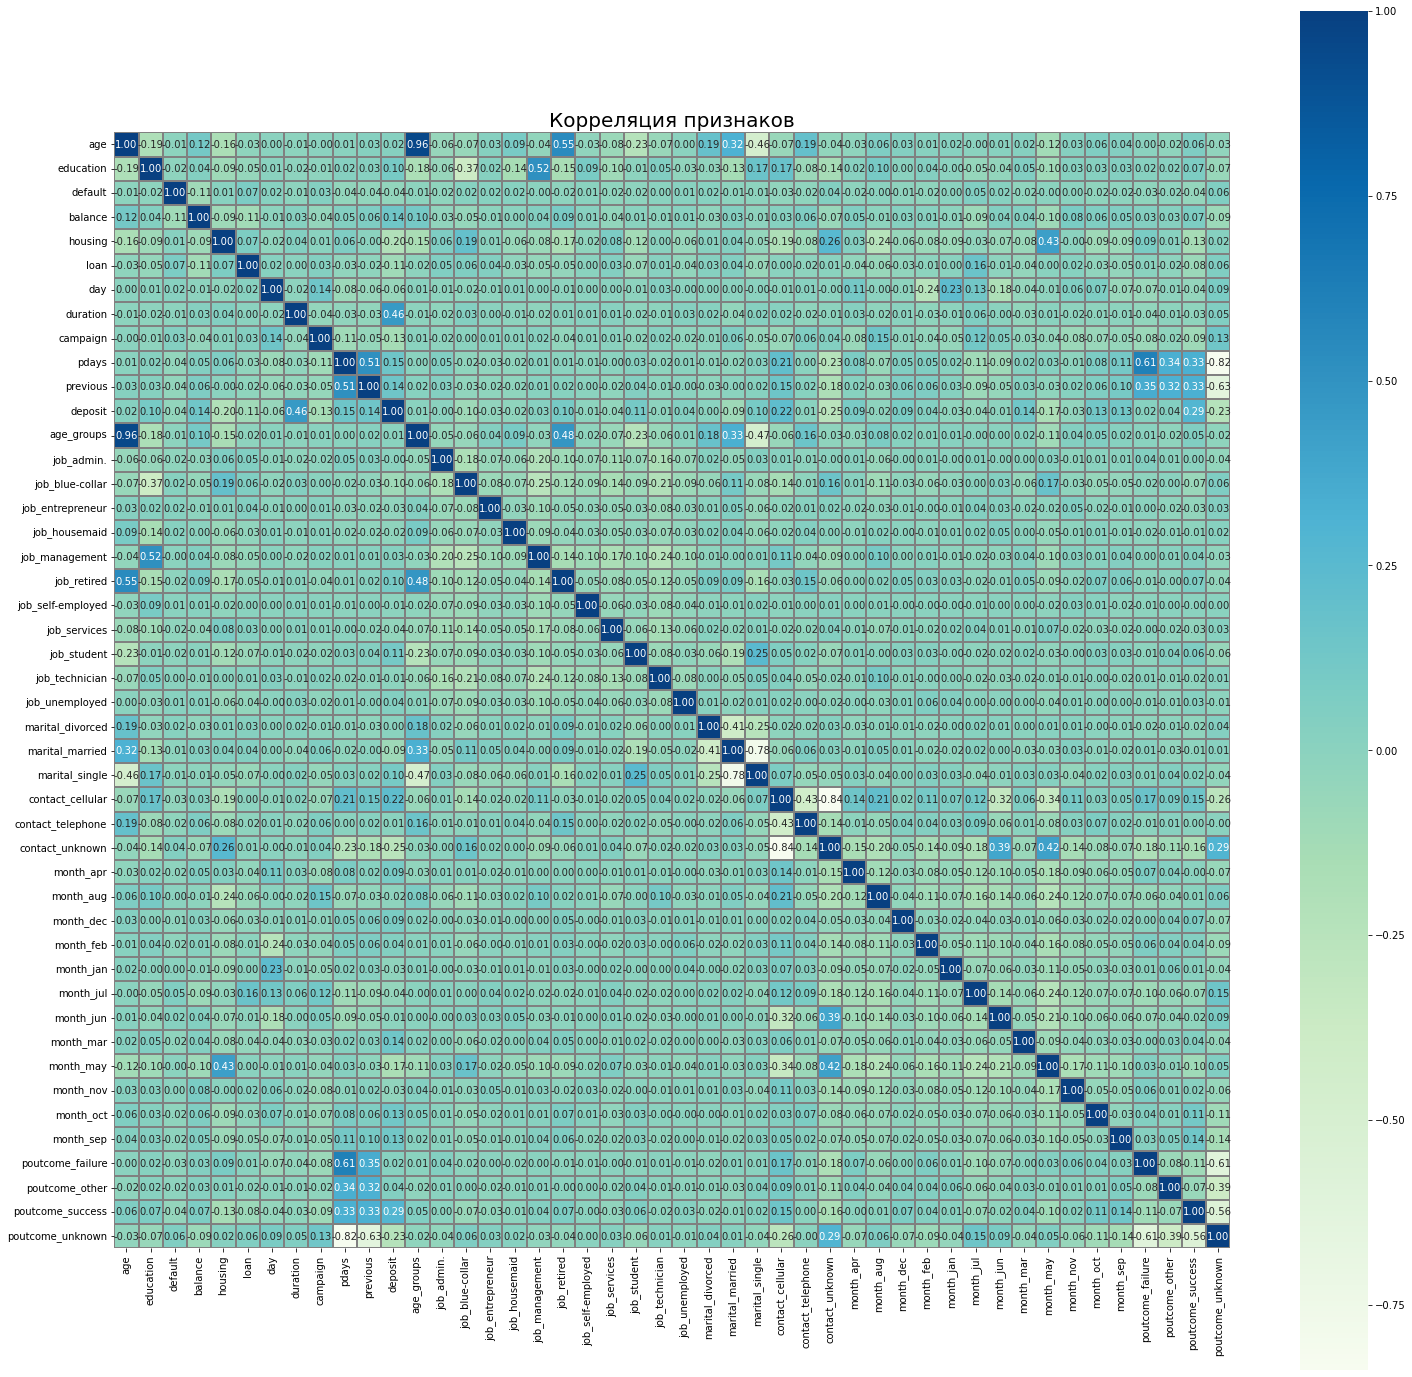

In [25]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

plt.subplots(figsize=(25, 25))
heatmap = sns.heatmap(
    df.corr(), 
    linewidth=0.1, 
    linecolor='gray',
    cmap='GnBu',
    annot = True,
    fmt='.2f',
    square=True
)

# задаём заголовок
heatmap.set_title('Корреляция признаков', fontsize=20);

### Задания 7 и 8

In [26]:
X = df.drop(['deposit','age'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    random_state = RANDOM_STATE, 
                                                    test_size = 0.33)

In [27]:
# рассчитайте необходимые показатели

print('Размер тестовой выборки = {}'.format(X_test.shape[0]))
print('Среднее значение целевой переменной на тестовой выборке = {}'.format(round(y_test.mean(), 2)))

Размер тестовой выборки = 3335
Среднее значение целевой переменной на тестовой выборке = 0.46


### Задание 9

In [28]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

k = 20
skb = SelectKBest(score_func = f_classif, k=k)
skb.fit_transform(X_train, y_train)
best_feature_list = list(skb.get_feature_names_out())
X_new_train = X_train[best_feature_list]
X_new_test = X_test[best_feature_list]
print(best_feature_list)

['education', 'balance', 'housing', 'loan', 'duration', 'campaign', 'pdays', 'previous', 'job_blue-collar', 'job_retired', 'job_student', 'contact_cellular', 'contact_unknown', 'month_apr', 'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown']


### Задание 10

In [29]:
# нормализуйте данные с помощью minmaxsxaler

scaler = MinMaxScaler()
scaler.fit(X_new_train)
X_new_train_scaled = scaler.transform(X_new_train)
X_new_test_scaled = scaler.transform(X_new_test)
print(round(X_new_test_scaled[:,0].mean(),2))

0.6


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [30]:
# обучите логистическую регрессию и рассчитайте метрики качества

lr = linear_model.LogisticRegression(solver = 'sag',                                      
                                     random_state = RANDOM_STATE,
                                     n_jobs=1,
                                     max_iter=1000)
lr.fit(X_new_train_scaled, y_train) 
y_pred = lr.predict(X_new_test_scaled)
print('accuracy_test  {}'.format(round(metrics.accuracy_score(y_test, y_pred),2)))

accuracy_test  0.81


### Задания 2,3,4

In [31]:
# обучите решающие деревья, настройте максимальную глубину

dt = tree.DecisionTreeClassifier(criterion = 'entropy',
                                random_state = RANDOM_STATE)
dt.fit(X_new_train_scaled, y_train) 
y_train_pred = dt.predict(X_new_train_scaled)
y_test_pred = dt.predict(X_new_test_scaled)
print('accuracy_train {}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('accuracy_test  {}'.format(metrics.accuracy_score(y_test, y_test_pred)))

accuracy_train 0.9998522895125553
accuracy_test  0.7502248875562219


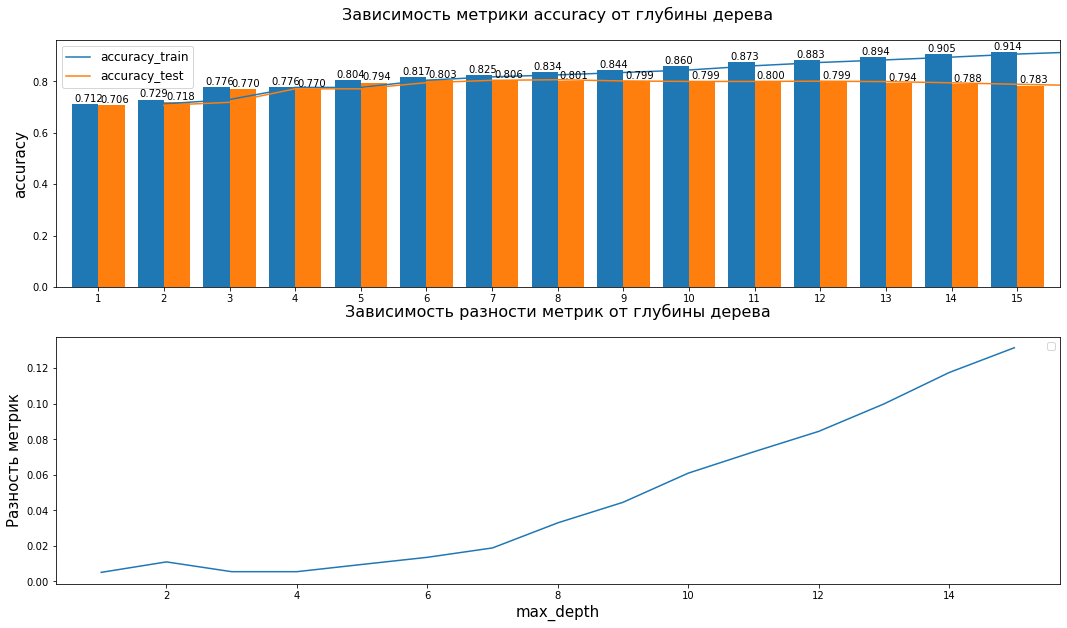

In [32]:
# настроим оптимальную максимальную глубину

to_df_string = dict()
accuracy_df = pd.DataFrame()
diff_df = pd.DataFrame()
max_depth_list = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
for max_depth in max_depth_list:
    dt = tree.DecisionTreeClassifier(criterion = 'entropy',
                                     max_depth = max_depth,
                                     random_state = RANDOM_STATE)
    dt.fit(X_new_train_scaled, y_train) 
    y_train_pred = dt.predict(X_new_train_scaled)
    y_test_pred = dt.predict(X_new_test_scaled)
    new_string = {'accuracy_train': metrics.accuracy_score(y_train, y_train_pred),
                  'accuracy_test': metrics.accuracy_score(y_test, y_test_pred),
                  'max_depth':max_depth}
    accuracy_df = accuracy_df.append(new_string, ignore_index = True)
    
fig, axes = plt.subplots(2,1,figsize=(18, 10))
plot_df = accuracy_df[['accuracy_train','accuracy_test']]
plot_df.index = range(1,len(plot_df)+1,1)
diff_df['diff'] = (plot_df['accuracy_train'] - plot_df['accuracy_test'])
diff_df.index = range(1,len(plot_df)+1,1)
plot = plot_df.plot(
    ax=axes[0], 
    kind='bar', 
    width=0.80, 
    rot=0)

plot = plot_df.plot(
    ax=axes[0], 
    rot=0)

axes[0].set_title('Зависимость метрики accuracy от глубины дерева', 
               pad = 20, 
               size=16)
axes[0].set_ylabel('accuracy', 
                fontsize=15)
axes[0].legend(['accuracy_train','accuracy_test'], 
            #loc='upper left', 
            fontsize=12)

for num in plot.patches:
    plot.annotate('{:.3f}'.format(num.get_height()), 
                  (num.get_x()+0.25, 
                  num.get_height()+0.002),
                  ha='center', 
                  va='bottom', 
                  fontsize=10)


plot = diff_df.plot(ax=axes[1])
axes[1].set_title('Зависимость разности метрик от глубины дерева', 
               pad = 20, 
               size=16)
axes[1].set_xlabel('max_depth', 
                fontsize=15)
axes[1].set_ylabel('Разность метрик', 
                fontsize=15)
axes[1].legend('')
plt.show();

Из сравнения значений метрики на тестовой и тренировочной выборках в зависимости от глубины дерава, говорить, что оптимальная глубина дерева равна 6.

### Задание 5

In [33]:
# подберите оптимальные параметры с помощью gridsearch

param_grid = [{'max_depth': [3,5,7],
              'min_samples_split': [2, 5, 7, 10]},]
base_estimator = tree.DecisionTreeClassifier(criterion = 'entropy',
                                             random_state = RANDOM_STATE)
grid = GridSearchCV(base_estimator, 
                    param_grid, 
                    cv=5)
grid.fit(X_new_train_scaled, y_train)

print('Оптимальные параметры: {}'.format(grid.best_params_))

dt_opt = tree.DecisionTreeClassifier(criterion = 'entropy',
                                     max_depth = grid.best_params_['max_depth'],
                                     min_samples_split = grid.best_params_['min_samples_split'],
                                     random_state = RANDOM_STATE)
dt_opt.fit(X_new_train_scaled, y_train) 
y_train_pred = dt_opt.predict(X_new_train_scaled)
y_test_pred = dt_opt.predict(X_new_test_scaled)
print('accuracy_train {}'.format(round(metrics.f1_score(y_train, y_train_pred),2)))
print('accuracy_test  {}'.format(round(metrics.f1_score(y_test, y_test_pred),2)))

Оптимальные параметры: {'max_depth': 7, 'min_samples_split': 10}
accuracy_train 0.8
accuracy_test  0.78


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [34]:
# обучите на ваших данных случайный лес

rf = RandomForestClassifier(n_estimators = 100,
                            criterion = 'gini',
                            min_samples_leaf = 5,
                            max_depth = 10,
                            random_state = RANDOM_STATE
                            )
#Обучаем модель 
rf.fit(X_new_train_scaled, y_train)
#Делаем предсказание класса
y_rf_pred = rf.predict(X_new_test_scaled)
#Выводим отчёт о метриках
print('accuracy_test  {}'.format(round(metrics.accuracy_score (y_test, y_rf_pred),2)))
print('recall_test {}'.format(round(metrics.recall_score (y_test, y_rf_pred),4)))
print(metrics.classification_report(y_test, y_rf_pred))

accuracy_test  0.83
recall_test 0.8401
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1790
           1       0.81      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [35]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

gbc = GradientBoostingClassifier(learning_rate = 0.05, 
                                n_estimators = 300,
                                min_samples_leaf = 5,
                                max_depth = 5,
                                random_state = RANDOM_STATE) 

gbc.fit(X_new_train_scaled, y_train)
#Делаем предсказание класса
y_gbc_pred = gbc.predict(X_new_test_scaled)
#Выводим отчёт о метриках
print(metrics.classification_report(y_test, y_gbc_pred))

              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1790
           1       0.81      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [36]:
# объедините уже известные вам алгоритмы с помощью стекинга 

# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('dtc', tree.DecisionTreeClassifier(criterion = 'entropy', 
                                  max_depth = max_depth,
                                  random_state = RANDOM_STATE)),
    ('lr',  linear_model.LogisticRegression(solver = 'sag',                                      
                                            random_state = RANDOM_STATE,
                                            n_jobs=1,
                                            max_iter=1000)),
    ('gbc', GradientBoostingClassifier(learning_rate = 0.05, 
                                       n_estimators = 300,
                                       min_samples_leaf = 5,
                                       max_depth = 5,
                                       random_state = RANDOM_STATE)),
    ('rf', RandomForestClassifier(n_estimators = 100,
                                  criterion = 'gini',
                                  min_samples_leaf = 5,
                                  max_depth = 10,
                                  random_state = RANDOM_STATE))
]

# Создаем объект класса стекинг
reg = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(solver = 'sag',                                      
                                                    random_state = RANDOM_STATE,
                                                    n_jobs=1,
                                                    max_iter=1000)
)
# Обучаем модель
reg.fit(X_new_train_scaled, y_train)
# Формируем предсказание для тестовой выборки
y_pred_stack = reg.predict(X_new_test_scaled)
# Оцениваем качество по метрике precision
print('precision_test {}'.format(round(metrics.precision_score(y_test, y_pred_stack),2)))

precision_test 0.81


### Задание 5

In [37]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

from sklearn.feature_selection import RFE
estimator = GradientBoostingClassifier(learning_rate = 0.05, 
                                       n_estimators = 300,
                                       min_samples_leaf = 5,
                                       max_depth = 5,
                                       random_state = RANDOM_STATE)
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_new_train_scaled, y_train)
 
selector.get_feature_names_out()
columns = X_new_train.columns
ranc = selector.ranking_
for iranc in ranc:
    print(columns[ranc[iranc]])

previous
balance
balance
housing
balance
loan
contact_unknown
month_oct
balance
job_student
campaign
job_blue-collar
duration
contact_cellular
pdays
month_mar
poutcome_success
month_may
balance
job_retired


### Задания 6,7,8

In [38]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

import optuna
def optuna_rf(trial):
    
  # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=RANDOM_STATE)
  # обучаем модель
    model.fit(X_new_train_scaled, y_train)
    score = metrics.f1_score(y_test, model.predict(X_new_test_scaled))

    return score

# cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=RANDOM_STATE, )
model.fit(X_new_train_scaled, y_train)
y_test_pred = model.predict(X_new_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('accuracy_score на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

[I 2023-10-19 10:43:53,151] A new study created in memory with name: RandomForestClassifier
[I 2023-10-19 10:43:54,303] Trial 0 finished with value: 0.8275645059786029 and parameters: {'n_estimators': 179, 'max_depth': 26, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8275645059786029.
[I 2023-10-19 10:43:55,091] Trial 1 finished with value: 0.8262108262108262 and parameters: {'n_estimators': 131, 'max_depth': 10, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8275645059786029.
[I 2023-10-19 10:43:56,323] Trial 2 finished with value: 0.8289763779527559 and parameters: {'n_estimators': 174, 'max_depth': 28, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.8289763779527559.
[I 2023-10-19 10:43:57,008] Trial 3 finished with value: 0.8271101349231252 and parameters: {'n_estimators': 101, 'max_depth': 21, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8289763779527559.
[I 2023-10-19 10:43:57,970] Trial 4 finished with value: 0.8297738693467337 and parameters: {'n_

f1_score на тестовом наборе: 0.83
accuracy_score на тестовом наборе: 0.84
